In [279]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold

df = pd.read_csv('/Users/p.devine/Documents/GitHub/Academic-Success-Predictor/data/df_vif_cleaned.csv')

X = df.drop(columns=['result_pass'])

y = df['result_pass'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.6846
Confusion Matrix:
[[28 29]
 [12 61]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.49      0.58        57
           1       0.68      0.84      0.75        73

    accuracy                           0.68       130
   macro avg       0.69      0.66      0.66       130
weighted avg       0.69      0.68      0.67       130



In [280]:
# Train a logistic regression model with L1 regularization
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_l1.fit(X_train, y_train)

# Print feature importance
importance = np.abs(model_l1.coef_).flatten()
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
print(feature_importance.sort_values(by='Importance', ascending=False))

#L1 (lasso) Regularisation to see which features matters most

              Feature  Importance
8              higher    1.844099
2            failures    1.679951
3           schoolsup    1.309615
20       Mjob_at_home    0.981472
15          school_MS    0.913023
32    guardian_mother    0.528392
6          activities    0.485749
16              sex_M    0.443534
1           studytime    0.390775
11               Dalc    0.322703
29        reason_home    0.318052
17          address_U    0.274388
26      Fjob_services    0.266031
23       Mjob_teacher    0.122507
18        famsize_LE3    0.113034
24       Fjob_at_home    0.098982
0          traveltime    0.097287
13             health    0.097030
9            internet    0.091513
27       Fjob_teacher    0.087855
5                paid    0.087091
30  reason_reputation    0.080090
14           absences    0.071873
28      reason_course    0.068769
4              famsup    0.063101
12               Walc    0.033803
7             nursery    0.020338
25        Fjob_health    0.000000
22      Mjob_s

In [281]:
df2 = df.drop(columns = [ 'famsup', 'Fjob_health', 'Pstatus_T', 'nursery', 'reason_reputation', 'romantic', 'Walc', 'guardian_father', 'Mjob_health', 'Mjob_services', 'reason_course', 
                         'reason_reputation'])

X = df2.drop(columns=['result_pass'])

y = df2['result_pass'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.7154
Confusion Matrix:
[[29 28]
 [ 9 64]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.51      0.61        57
           1       0.70      0.88      0.78        73

    accuracy                           0.72       130
   macro avg       0.73      0.69      0.69       130
weighted avg       0.73      0.72      0.70       130



In [282]:
print(df["result_pass"].value_counts())

result_pass
1    348
0    301
Name: count, dtype: int64


In [283]:
X = df2.drop(columns=['result_pass'])
y = df2['result_pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Define hyperparameter grid
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    "solver": ["liblinear", "lbfgs", "saga"],  # Different solvers for optimization
}

# Initialize logistic regression model
log_reg = LogisticRegression(max_iter=10000)

# Perform Grid Search with Cross-Validation (CV=5)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)

print(f"Best Parameters: {best_params}")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))


Best Parameters: {'C': 1, 'solver': 'liblinear'}
Accuracy: 0.7230769230769231
Confusion Matrix:
 [[33 24]
 [12 61]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.58      0.65        57
           1       0.72      0.84      0.77        73

    accuracy                           0.72       130
   macro avg       0.73      0.71      0.71       130
weighted avg       0.72      0.72      0.72       130



In [284]:

misclassified = X_test[y_test != y_pred_best]
misclassified['true_label'] = y_test[y_test != y_pred_best]
misclassified['predicted_label'] = y_pred_best[y_test != y_pred_best]

# Analyze common features in misclassified instances
print(misclassified.describe())
print(misclassified.groupby('true_label').mean())

       traveltime  studytime   failures  schoolsup       paid  activities  \
count   36.000000  36.000000  36.000000  36.000000  36.000000   36.000000   
mean     1.472222   1.972222   0.055556   0.194444   0.027778    0.361111   
std      0.736250   0.909823   0.232311   0.401386   0.166667    0.487136   
min      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
25%      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
50%      1.000000   2.000000   0.000000   0.000000   0.000000    0.000000   
75%      2.000000   2.000000   0.000000   0.000000   0.000000    1.000000   
max      4.000000   4.000000   1.000000   1.000000   1.000000    1.000000   

       higher   internet       Dalc    health  ...  famsize_LE3  Mjob_at_home  \
count    36.0  36.000000  36.000000  36.00000  ...    36.000000     36.000000   
mean      1.0   0.777778   1.444444   3.75000  ...     0.388889      0.166667   
std       0.0   0.421637   0.734631   1.48083  ...     0.494413

/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_33149/347198450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['true_label'] = y_test[y_test != y_pred_best]
/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_33149/347198450.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_label'] = y_pred_best[y_test != y_pred_best]


In [285]:
df2['studytime_failures'] = df2['studytime'] * df2['failures']
df2['paid_schoolsup'] = df2['paid'] * df2['schoolsup']
df2['health_absences'] = df2['health'] * df2['absences']
df2['absences_studytime'] = df2['absences'] * df2['studytime']
df2['Dalc_health'] = df2['Dalc'] * df2['health']
df2['traveltime_schoolsup'] = df2['traveltime'] * df2['schoolsup']

# Step 2: Define features (X) and target variable (y)
X = df2.drop(columns=['result_pass'])
y = df2['result_pass']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Step 5: Train a Logistic Regression model on the SMOTE-resampled data
model = LogisticRegression(max_iter=1000)
model.fit(X_train_smote, y_train_smote)

# Step 6: Predict on the test set
y_pred = model.predict(X_test)

# Step 7: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7307692307692307
Confusion Matrix:
 [[33 24]
 [11 62]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.58      0.65        57
           1       0.72      0.85      0.78        73

    accuracy                           0.73       130
   macro avg       0.74      0.71      0.72       130
weighted avg       0.73      0.73      0.72       130



In [286]:
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_l1.fit(X_train_smote, y_train_smote)

importance = np.abs(model_l1.coef_).flatten()
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
print(feature_importance.sort_values(by='Importance', ascending=False))

#L1 (lasso) Regularisation to see which features matters most

                 Feature  Importance
6                 higher    1.613007
3              schoolsup    1.358630
15          Mjob_at_home    0.887647
11             school_MS    0.713449
2               failures    0.677690
1              studytime    0.654951
5             activities    0.575181
22    studytime_failures    0.571482
21       guardian_mother    0.408087
13             address_U    0.400630
12                 sex_M    0.316439
8                   Dalc    0.286480
20           reason_home    0.271792
19          Fjob_teacher    0.235410
4                   paid    0.194173
16          Mjob_teacher    0.184913
27  traveltime_schoolsup    0.180086
18         Fjob_services    0.178242
17          Fjob_at_home    0.149941
0             traveltime    0.131406
9                 health    0.112249
25    absences_studytime    0.059511
14           famsize_LE3    0.041167
10              absences    0.032795
26           Dalc_health    0.025019
7               internet    0.001677
2

In [287]:
classifier = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

kfold = KFold(10, shuffle = True, random_state =42)
for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
    print(f"Fold {i}:")
    print(f" Train: index={train_index}")
    print(f" Test: index={test_index}")

scores = cross_val_score(classifier, X ,y, cv=kfold, scoring = 'accuracy')

average_acc = np.mean(scores)

print(f"Accuracy Score for each fold: {[round(score,4) for score in scores]}")
print(f"Average accuracy across 10 folds: {average_acc: .2f}")


Fold 0:
 Train: index=[  0   1   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  32  33  34  35  36  37  38  39
  40  41  42  43  45  46  47  48  49  50  51  52  53  56  57  58  59  60
  61  62  64  65  66  67  68  70  71  73  74  75  77  79  80  82  83  84
  85  86  87  88  89  91  92  93  94  95  96  97  98  99 100 102 103 104
 105 106 107 108 109 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 159 160 161
 162 163 164 166 167 168 169 170 171 172 173 175 178 179 180 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 211 212 213 214 215 216 217 218 219 221 222 223
 224 225 226 227 228 229 230 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 248 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 265 266 267 268 269 270 

In [288]:
X = df2.drop(columns=['result_pass', 'health_absences', 'paid_schoolsup', 'internet', 'Dalc_health', 'absences', 'famsize_LE3'])
y = df2['result_pass']

smote = SMOTE(random_state=42)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
conf_matrices = []
class_reports = []

for train_index, val_index in kf.split(X, y):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_smote, y_train_smote)
    
    y_pred = model.predict(X_val)
    
    accuracies.append(accuracy_score(y_val, y_pred))
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    class_reports.append(classification_report(y_val, y_pred, output_dict=True))

avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_class_report = np.mean([report['accuracy'] for report in class_reports])

print("Average Accuracy: {:.4f}".format(avg_accuracy))
print("Average Confusion Matrix:\n", avg_conf_matrix)
print("Average Classification Report (accuracy): {:.4f}".format(avg_class_report))




Average Accuracy: 0.7488
Average Confusion Matrix:
 [[21.   9.1]
 [ 7.2 27.6]]
Average Classification Report (accuracy): 0.7488


In [305]:
X = df2.drop(columns=['result_pass', 'traveltime', 'absences', 'Dalc', 'internet'])
y = df2['result_pass']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

smote = SMOTE(random_state=42)

param_grid = {
    'penalty': ['l1', 'l2'],  
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'solver': ['liblinear', 'saga'], 
    'max_iter': [10000, 50000, 100000]  
}

model = LogisticRegression()

grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    cv=kf,  
    scoring='accuracy',  
    n_jobs=-1  
)

best_params = None
best_score = 0

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    grid_search.fit(X_train_smote, y_train_smote)
    
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Accuracy: {best_score:.4f}")


Best Hyperparameters: {'C': 1, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracy: 0.7860


In [310]:
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.7881
Test Accuracy: 0.7000


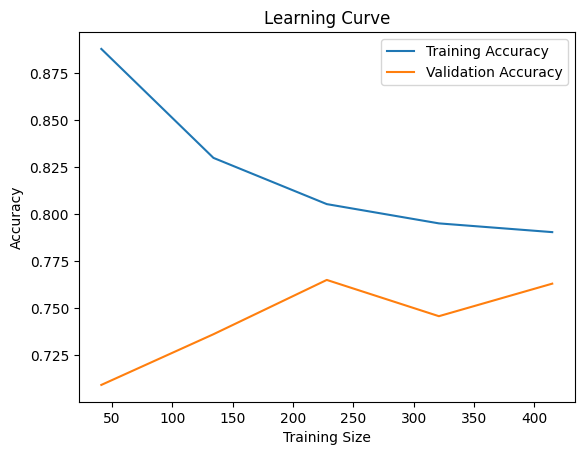

In [311]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve")
plt.show()
